## Problem - Customer Churn

We work for a fictitious telecommunications company 

One of the most important goals of the company is to increase customer loyalty. 

One strategy to achieve this goal is to identify customers who are likely to churn and approach them before they leave.

To do this, we'll look at historical customer data and see if we can develop a model that predicts churn based on various customer factors such as contract length, monthly payments, demographic information, etc.

This model would then help us to identify customers with a high risk of churn early enough so marketing could still address them e.g. with promotional packages.

## Feature Engineering

### Get Data

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
df = pd.read_csv("https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv")
df = df.query("Contract == 'Month-to-month'")

In [52]:
# Define X and y
X = df.drop(['Churn'], axis = 1)
y = df['Churn']
y = y.map(dict(Yes=1, No=0))

# Stratified train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify= y )

In [53]:
print(pd.Series(y_train).value_counts(normalize = True))
print(pd.Series(y_test).value_counts(normalize = True))

Churn
0    0.572903
1    0.427097
Name: proportion, dtype: float64
Churn
0    0.572903
1    0.427097
Name: proportion, dtype: float64


In [54]:
X_train.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
6028,1871-MOWRM,Male,0,Yes,No,12,Yes,No,Fiber optic,Yes,No,No,Yes,No,No,Month-to-month,No,Bank transfer (automatic),80.85,866.45
4645,5219-YIPTK,Female,0,Yes,No,33,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,104.40,3409.6
5958,6859-RKMZJ,Male,0,Yes,No,11,Yes,No,DSL,No,No,No,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),55.05,608.15
6031,0282-NVSJS,Female,1,Yes,Yes,12,No,No phone service,DSL,No,No,No,Yes,No,No,Month-to-month,Yes,Mailed check,29.30,355.9
459,1452-VOQCH,Male,0,No,No,1,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,75.10,75.1


Drop features we don't want to have:

* `customerID` does not generalize
* we don't want `gender` for ethical reasons
* `Contract` is only Month-to-month as per our definition

In [55]:
X_train = X_train.drop(['customerID', 'gender', 'Contract'], axis = 1)

Separate numeric from categorical columns

In [56]:
num_cols = X_train._get_numeric_data().columns
num_cols

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges'], dtype='object')

Encode `SeniorCitizen` as string

In [57]:
X_train['SeniorCitizen'] = X_train['SeniorCitizen'].astype(str)

Encode `TotalCharges` as numeric

In [58]:
X_train['TotalCharges'] = X_train['TotalCharges'].astype(float)

In [59]:
num_cols = X_train._get_numeric_data().columns
num_cols

Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

In [60]:
cat_cols = X_train.drop(num_cols, axis = 1).columns
cat_cols

Index(['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

## Numeric columns: scaling

array([[<Axes: title={'center': 'tenure'}>,
        <Axes: title={'center': 'MonthlyCharges'}>],
       [<Axes: title={'center': 'TotalCharges'}>, <Axes: >]], dtype=object)

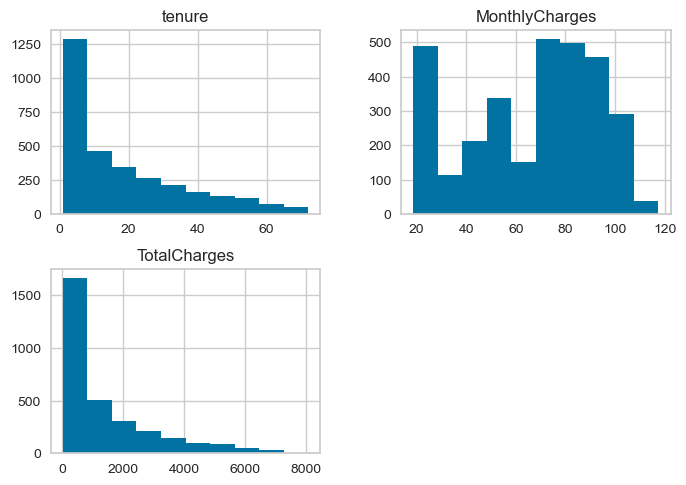

In [61]:
X_train[num_cols].hist()

Log-Transform tenure and Total Charges

In [62]:
from sklearn.preprocessing import power_transform

In [63]:
X_train[['tenure_power', 'TotalCharges_power']] = power_transform(X_train[['tenure', 'TotalCharges']], method='box-cox')

array([[<Axes: title={'center': 'tenure_power'}>,
        <Axes: title={'center': 'TotalCharges_power'}>]], dtype=object)

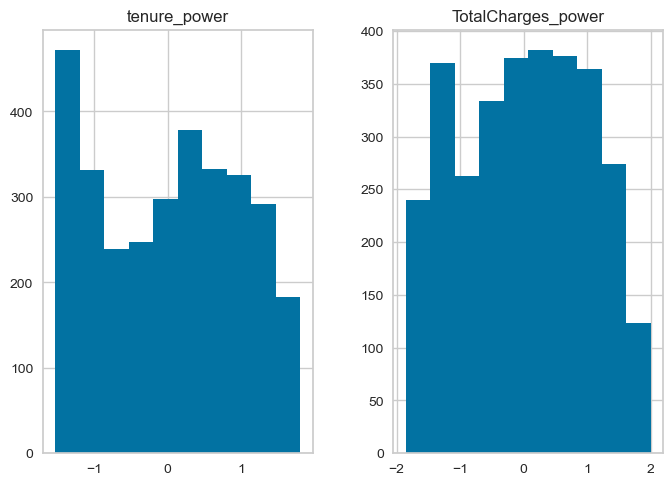

In [64]:
X_train[['tenure_power', 'TotalCharges_power']].hist()

Scale numeric features to the same scale:

In [65]:
def ab_scaler(x, a, b, max_x, min_x):
  return a + ((x - min_x)*(b-a)) / (max_x - min_x)

In [66]:
for column in ['tenure_power', 'TotalCharges_power', 'MonthlyCharges']:
  max = X_train[column].max()
  min = X_train[column].min()
  new_col = str(column + "_scaled")
  X_train[new_col] = X_train[column].apply(lambda x: ab_scaler(x =x, a=-1, b=1, max_x = max, min_x = min))

In [67]:
numeric_features = X_train.filter(regex='_scaled', axis=1).reset_index(drop = True)

array([[<Axes: title={'center': 'tenure_power_scaled'}>,
        <Axes: title={'center': 'TotalCharges_power_scaled'}>],
       [<Axes: title={'center': 'MonthlyCharges_scaled'}>, <Axes: >]],
      dtype=object)

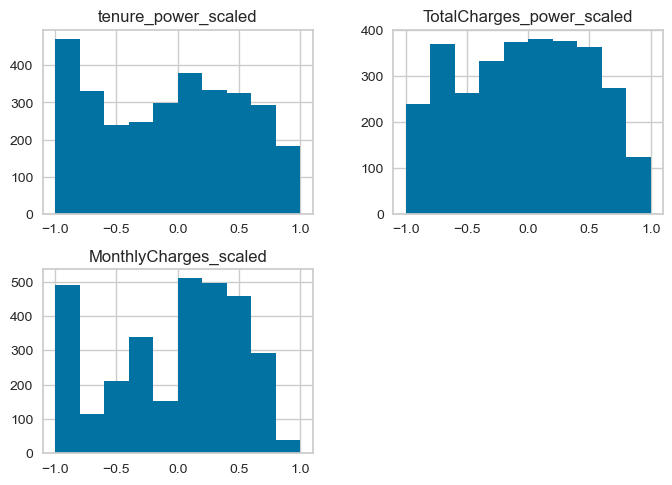

In [68]:
numeric_features.hist()

## Categorical Columns - Encoding

In [69]:
for column in cat_cols:
  print(X_train[column].value_counts())

SeniorCitizen
0    2455
1     645
Name: count, dtype: int64
Partner
No     1984
Yes    1116
Name: count, dtype: int64
Dependents
No     2467
Yes     633
Name: count, dtype: int64
PhoneService
Yes    2790
No      310
Name: count, dtype: int64
MultipleLines
No                  1618
Yes                 1172
No phone service     310
Name: count, dtype: int64
InternetService
Fiber optic    1698
DSL             980
No              422
Name: count, dtype: int64
OnlineSecurity
No                     2102
Yes                     576
No internet service     422
Name: count, dtype: int64
OnlineBackup
No                     1836
Yes                     842
No internet service     422
Name: count, dtype: int64
DeviceProtection
No                     1932
Yes                     746
No internet service     422
Name: count, dtype: int64
TechSupport
No                     2156
Yes                     522
No internet service     422
Name: count, dtype: int64
StreamingTV
No                     1651
Yes 

Turn binary feature into numeric, and multi-class features into dummy variables

### Binary features

In [70]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [71]:
binary_cols = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

for column in binary_cols:
  new_col = str(column + "_be")
  X_train[new_col] = encoder.fit_transform(X_train[column])

In [72]:
binary_features = X_train.filter(regex='_be', axis=1).reset_index(drop = True)

In [73]:
binary_features.head()

,SeniorCitizen_be,Partner_be,Dependents_be,PhoneService_be,PaperlessBilling_be
0,0,1,0,1,0
1,0,1,0,1,1
2,0,1,0,1,1
3,1,1,1,0,1
4,0,0,0,1,1


### Multiclass features

In [74]:
multiclass_cols = list(set(cat_cols) - set(binary_cols))
multiclass_cols

['OnlineBackup',
 'InternetService',
 'TechSupport',
 'StreamingMovies',
 'StreamingTV',
 'MultipleLines',
 'DeviceProtection',
 'PaymentMethod',
 'OnlineSecurity']

In [75]:
categories = []

for column in multiclass_cols:
  categories.append(X_train[column].unique())

categories

[array(['No', 'Yes', 'No internet service'], dtype=object),
 array(['Fiber optic', 'DSL', 'No'], dtype=object),
 array(['Yes', 'No', 'No internet service'], dtype=object),
 array(['No', 'Yes', 'No internet service'], dtype=object),
 array(['No', 'Yes', 'No internet service'], dtype=object),
 array(['No', 'Yes', 'No phone service'], dtype=object),
 array(['No', 'Yes', 'No internet service'], dtype=object),
 array(['Bank transfer (automatic)', 'Electronic check', 'Mailed check',
        'Credit card (automatic)'], dtype=object),
 array(['Yes', 'No', 'No internet service'], dtype=object)]

In [76]:
from sklearn.preprocessing import OneHotEncoder

# specify categories explicitly to allow for same encoding during prediction
onehot_encoder = OneHotEncoder(sparse=False, categories = categories)

In [77]:
# Apply OneHotEncoder
multiclass_features = onehot_encoder.fit_transform(X_train[multiclass_cols])

c:\Users\Rina\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [78]:
multiclass_features = pd.DataFrame(multiclass_features, columns=onehot_encoder.get_feature_names_out())

In [79]:
multiclass_features.head()

,OnlineBackup_No,OnlineBackup_Yes,OnlineBackup_No internet service,InternetService_Fiber optic,InternetService_DSL,InternetService_No,TechSupport_Yes,TechSupport_No,TechSupport_No internet service,StreamingMovies_No,...,DeviceProtection_No,DeviceProtection_Yes,DeviceProtection_No internet service,PaymentMethod_Bank transfer (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaymentMethod_Credit card (automatic),OnlineSecurity_Yes,OnlineSecurity_No,OnlineSecurity_No internet service
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### Build feature dataframe

In [80]:
X_train_fe = pd.concat([numeric_features, binary_features, multiclass_features], axis = 1)

In [81]:
X_train_fe.head()

,tenure_power_scaled,TotalCharges_power_scaled,MonthlyCharges_scaled,SeniorCitizen_be,Partner_be,Dependents_be,PhoneService_be,PaperlessBilling_be,OnlineBackup_No,OnlineBackup_Yes,...,DeviceProtection_No,DeviceProtection_Yes,DeviceProtection_No internet service,PaymentMethod_Bank transfer (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaymentMethod_Credit card (automatic),OnlineSecurity_Yes,OnlineSecurity_No,OnlineSecurity_No internet service
0,-0.037704,0.066415,0.258359,0,1,0,1,0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.504461,0.605726,0.735562,0,1,0,1,1,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,-0.079644,-0.057262,-0.264438,0,1,0,1,1,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.037704,-0.233416,-0.786221,1,1,1,0,1,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-1.000000,-0.677466,0.141844,0,0,0,1,1,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### Feature selection

In [82]:
from sklearn.feature_selection import RFECV
from sklearn import linear_model
model = linear_model.LogisticRegression()

selector = RFECV(
    estimator=model,
    min_features_to_select=3,
    scoring="f1",
    cv=5,
)

selector.fit(X_train_fe, y_train)


RFECV(cv=5, estimator=LogisticRegression(), min_features_to_select=3,
      scoring='f1')

`.support_` gives a boolean mask with False values for discarded features which we can use to filter the training dataframe

In [83]:

X_train_fe.columns[selector.support_]
len(X_train_fe.columns[selector.support_])

13

In [84]:
!pip install yellowbrick

In [85]:
from yellowbrick.model_selection import RFECV

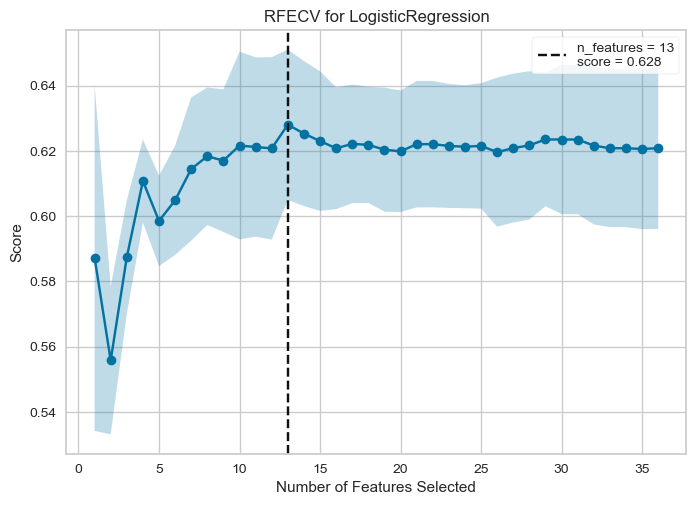

<Axes: title={'center': 'RFECV for LogisticRegression'}, xlabel='Number of Features Selected', ylabel='Score'>

In [86]:
# Instantiate RFECV visualizer with a linear SVM classifier
visualizer = RFECV(    estimator=model,
    min_features_to_select=3,
    scoring="f1",
    cv=5,)

visualizer.fit(X_train_fe, y_train)      # Fit the data to the visualizer
visualizer.show()      

Keep only the important features

In [87]:
X_train_fe = X_train_fe.loc[:,selector.support_]
X_train_fe.head()

,tenure_power_scaled,TotalCharges_power_scaled,SeniorCitizen_be,PaperlessBilling_be,InternetService_Fiber optic,InternetService_DSL,TechSupport_No,StreamingMovies_No internet service,StreamingTV_Yes,StreamingTV_No internet service,MultipleLines_No,PaymentMethod_Electronic check,OnlineSecurity_No
0,-0.037704,0.066415,0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.504461,0.605726,0,1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
2,-0.079644,-0.057262,0,1,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,-0.037704,-0.233416,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-1.000000,-0.677466,0,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


## Model training

In [88]:
from sklearn.model_selection import GridSearchCV

# Define grid
parameters = {'class_weight': [None, 'balanced'], 'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

model = linear_model.LogisticRegression(fit_intercept = True, max_iter = 1000)

grid_search = GridSearchCV(model, parameters, cv = 5, scoring = "f1")
grid_search.fit(X_train_fe, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'class_weight': [None, 'balanced'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='f1')

In [89]:
pd.DataFrame((grid_search.cv_results_)).sort_values("rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,0.009458,0.006478,0.001351,0.002703,balanced,liblinear,"{'class_weight': 'balanced', 'solver': 'liblin...",0.646749,0.663102,0.677656,0.696915,0.660714,0.669027,0.017045,1
5,0.017286,0.002110,0.000000,0.000000,balanced,newton-cg,"{'class_weight': 'balanced', 'solver': 'newton...",0.649123,0.661922,0.673993,0.696915,0.660714,0.668533,0.016229,2
6,0.008630,0.007372,0.003130,0.006260,balanced,lbfgs,"{'class_weight': 'balanced', 'solver': 'lbfgs'}",0.649123,0.661922,0.673993,0.696915,0.660714,0.668533,0.016229,2
8,0.019024,0.003854,0.000000,0.000000,balanced,sag,"{'class_weight': 'balanced', 'solver': 'sag'}",0.649123,0.661922,0.673993,0.696915,0.660714,0.668533,0.016229,2
9,0.032260,0.002487,0.001395,0.002790,balanced,saga,"{'class_weight': 'balanced', 'solver': 'saga'}",0.649123,0.661922,0.673993,0.696915,0.660714,0.668533,0.016229,2


Train on all training data

In [90]:
best_model = grid_search.best_estimator_

# Train model on full training set
best_model.fit(X_train_fe, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')

Plot feature importance

<Axes: xlabel='Feature'>

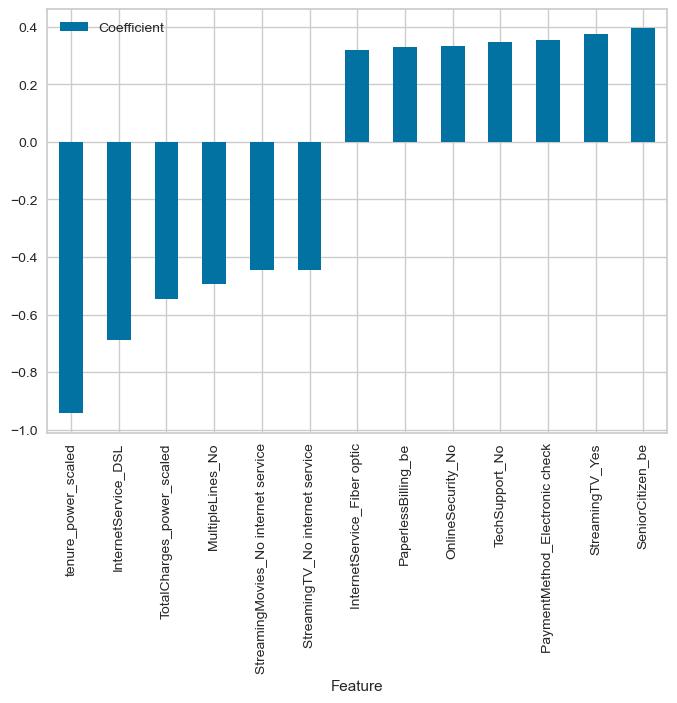

In [91]:
# Feature Importance
feature_importance_df = pd.DataFrame({"Feature": list(X_train_fe.columns), "Coefficient": best_model.coef_[0]})
feature_importance_df.sort_values("Coefficient").plot.bar(x = "Feature", y="Coefficient")

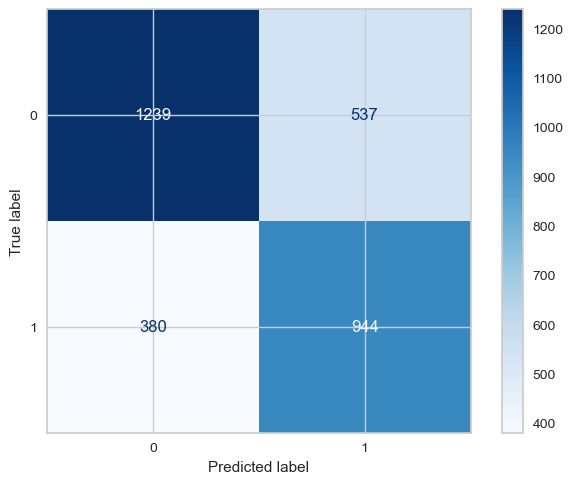

In [92]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = best_model.predict(X_train_fe)

cm = confusion_matrix(y_train, y_pred, labels = best_model.classes_)
plt = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model .classes_)
plt.plot(cmap = "Blues");

In [93]:
from sklearn.metrics import f1_score, accuracy_score

print(f'f1 score {f1_score(y_train, y_pred)}')
print(f'accuracy score {accuracy_score(y_train, y_pred)}')

f1 score 0.6730837789661319
accuracy score 0.7041935483870968


## Model evaluation

Inference pipeline

In [94]:
# Numeric features
# Applying power transformation as we did during training 
X_test[['tenure_power', 'TotalCharges_power']] = power_transform(X_test[['tenure', 'TotalCharges']], method='box-cox')



# Applying min-max normalization as we did during training 
for column in ['tenure_power', 'TotalCharges_power', 'MonthlyCharges']:
  max = X_train[column].max() # keep stats from training
  min = X_train[column].min() # keep stats from training
  new_col = str(column + "_scaled")
  X_test[new_col] = X_test[column].apply(lambda x: ab_scaler(x =x, a=-1, b=1, max_x = max, min_x = min))
  

# keep only scaled features  
numeric_features_test = X_test.filter(regex='_scaled', axis=1).reset_index(drop = True)
  
# Categorical features - apply label encoding on binary features
for column in binary_cols:
  new_col = str(column + "_be")
  X_test[new_col] = encoder.fit_transform(X_test[column])

# keep only label-encoded columns
binary_features_test = X_test.filter(regex='_be', axis=1).reset_index(drop = True)

# Categorical features - apply one-hot encoding
onehot_encoder = OneHotEncoder(sparse=False, categories = categories) # same categories as in training
multiclass_features_test = onehot_encoder.fit_transform(X_test[multiclass_cols])
multiclass_features_test = pd.DataFrame(multiclass_features_test, columns=onehot_encoder.get_feature_names_out())

# Join all features (i.e., numerical + binary + categorical)
X_test_fe = pd.concat([numeric_features_test, binary_features_test, multiclass_features_test], axis = 1)

# Keep only relevant features
X_test_fe = X_test_fe.loc[:,selector.support_]


c:\Users\Rina\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Evaluation

In [95]:
from sklearn.metrics import f1_score, accuracy_score

# Calculate F1-Score for test set
y_pred = best_model.predict(X_test_fe)
print(f'f1 score {f1_score(y_test, y_pred)}')
print(f'accuracy score {accuracy_score(y_test, y_pred)}')

f1 score 0.6704545454545455
accuracy score 0.7006451612903226


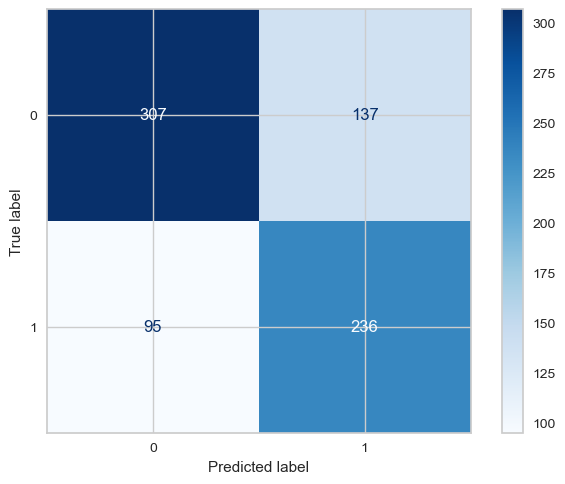

In [96]:
cm = confusion_matrix(y_test, y_pred, labels = best_model.classes_)
plt = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model .classes_)
plt.plot(cmap = "Blues");